<a href="https://colab.research.google.com/github/rato42/linear_regression/blob/unstable-yeah-sure/CLASSBASED_new_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [400]:
import sys

# Detect Colab environment
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import drive, auth
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaIoBaseDownload
    !pip install pwlf

    import pwlf

    auth.authenticate_user()
    drive.mount("/content/drive")
else:
    import pwlf
    from oauth2client.service_account import ServiceAccountCredentials

    print("Running outside Colab (VS Code/local)")

try:
    import gspread
except ModuleNotFoundError:
    if IN_COLAB and "google.colab" in str(get_ipython()):
        %pip install gspread
    import gspread

from gspread_dataframe import set_with_dataframe

Running outside Colab (VS Code/local)


In [401]:

import os

import time

import math
import scipy.stats as stats
import pandas as pd
import numpy as np


from sklearn.linear_model import Ridge
import statsmodels.api as sm

from openpyxl import load_workbook
from openpyxl.styles import Alignment

from scipy.stats import linregress, ttest_ind, ttest_rel, ttest_1samp
import matplotlib.pyplot as plt
import re
from openpyxl.drawing.image import Image
from matplotlib.font_manager import FontProperties
from io import BytesIO
import statsmodels.formula.api as smf
import statsmodels.api as sm

from datetime import datetime, timedelta

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

from dateutil.relativedelta import relativedelta

from sklearn import set_config
set_config(display="diagram")

import logging
from typing import Dict, Any

import io

# LOAD --- data from gsheet if colab or local


In [402]:
dados_brutos = None
output_wksheet = None

input_path = "https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0"
output_path = "https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0"

local_input_path = (
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input.csv" ### poa
    #"D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total_RS.xlsx" ### rs
    "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\input\\input_backup_com_aps_total.xlsx"
)

output_wksheet = None

if IN_COLAB:
    import gspread
    from google.auth import default

    auth.authenticate_user()
    creds, _ = default()
    gc = gspread.authorize(creds)
    workbook = gc.open_by_url(input_path)
    worksheets = workbook.worksheets()
    output_wksheet = gc.open_by_url(output_path)
    dados_brutos = worksheets[0].get_all_values()
else:
    try:
        dados_brutos = pd.read_csv(local_input_path, header=None).values.tolist()
    except:
        dados_brutos = pd.read_excel(local_input_path, header=None).values.tolist()

# TODO LIST

In [403]:
# TODO: Adicionar dummy de interação para comparar SM e outros atendimentos

# TODO: Orthogonalise pospand trend (so to not have colinearity with months)

# TODO: analisar overfitting

# TODO: taxa. a população se mantem estavel? os serviços de saude se mantem estaveis?

# https://chatgpt.com/canvas/shared/68084b682c548191a92db280344e5474

--- Low HIGH COMPLEXITY

- [x] Data Quality & Exploration  
  - [x] Plot the raw time series and annotate intervention points.  
  - [x] Check for missing values, outliers, or data entry errors.  
  - [x] Verify your date index is consistent (e.g., monthly frequency).  

- [x] Descriptive Statistics  
  - [x] Compute summary statistics (mean, variance) before and after the pandemic.  
  - [x] Calculate and plot moving averages to smooth trends.  

- [x] Dummy Variable Audit  
  - [x] Confirm each dummy is coded 0/1 for the correct periods.  
  - [x] Review naming consistency and placement in the DataFrame.  

- [x] Basic Model Fit  
  - [x] Fit the current segmented regression (consults ~ time + level_dummy + slope_dummy + month_dummies + lockdown_outliers).  
  - [x] Inspect R², coefficient signs, and p-values to sanity-check effects.  Export this to a readeable format

--- MEDIUM COMPLEXITY

- [ ] Residual Diagnostics  
  - [X] Plot residuals vs. fitted values to check heteroscedasticity.  
  - [ ] Examine ACF/PACF of residuals:  
    - [X] First using OLS (to confirm the need for AR structure).  
    - [X] Then using Prais-Winsten (to assess remaining autocorrelation).  

- [ ] Autocorrelation & Robust SE  
  - [ ] If autocorrelation exists, adjust standard errors (e.g., Newey-West) or fit an autoregressive error structure (e.g., AR(1)).  
  - [ ] Since you’re using Prais-Winsten, this step may be partially addressed — verify with residuals.  

- [ ] Seasonality & Trend Flexibility  
  - [ ] Test alternative seasonal structures (e.g., Fourier terms) instead of month dummies.  
  - [ ] Consider adding a quadratic or spline-based time trend.  

- [ ] Outlier Handling  
  - [ ] Justify and potentially consolidate lockdown outlier dummies (pulse vs. step).  
  - [ ] Compare models with and without these outlier dummies (use AIC/BIC).  

- [ ] Multicollinearity Check  
  - [ ] Compute Variance Inflation Factors (VIFs) for covariates.  

--- HIGH COMPLEXITY

- [ ] Adicionar dummy de interação para comparar SM e outros atendimentos

- [ ] Time-Series Cross-Validation  
  - [ ] Implement rolling-origin evaluation to assess predictive performance.  
  - [ ] Compare cross-validated errors (e.g., RMSE) across model specs to detect overfitting.  

- [ ] Model Comparison & Selection  
  - [ ] Use information criteria (AIC/BIC) to compare alternative models.  
  - [ ] Evaluate nested models (e.g., with/without slope change) via likelihood ratio tests.  

- [ ] Advanced Interrupted Time Series Methods  
  - [ ] Explore Bayesian ITS or segmented regression with autoregressive integrated moving average (ARIMA) errors.  
  - [x] Consider structural break tests (e.g., Chow test) for formal change-point detection.  

- [ ] Sensitivity & Robustness  
  - [ ] Run sensitivity analyses using different intervention start/end dates.  
  - [ ] Test robustness to alternative outlier definitions or lag structures.  

- [ ] Forecasting & Counterfactuals  
  - [ ] Generate counterfactual predictions for the post-pandemic period.  
  - [ ] Visualize observed vs. counterfactual to illustrate intervention impact.

# ARGS --- Define Args


In [455]:
### ARGS

INDEPENDENT_VAR = "periodo"  ### Y
DEPENDENT_VAR = "valores"  ### X
DATE_NAME = "date"
VARIABLE_COLUMN_NAME = "variavel"
LOCAL_OUTPUT_PATH = "D:\\CodeStuff\\Stats\\colab_linear_regression\\linear_regression\\output\\output.xlsx"


MOVING_WINDOW = 12

######### DUMMIES ##########

MEDIA_MOVEL_AS_FEATURE = False
INCLUDE_MONTH_DUMMIES = False
INCLUDE_QUARTER_DUMMIES = True

### as quedas do primeiro lockdown nao são tão claras e a recuperação e queda parecem ser mais graduais
CHOQUE_INICIAL_START_DATE= "2020-03-01"
CHOQUE_INICIAL_END_DATE = "2020-07-01"#"2020-08-01" #month based

### abril e maio tiveram quedas bem identificaveis nos atendimentos em todas variavieis
SECONDLOCKDOWN_START_DATE = "2021-04-01"
SECONDLOCKDOWN_END_DATE = '2021-05-01' #month based  #'2021-04-01'#quarter_based #

POS_PANDEMIA_START_DATE = "2022-01-01"
END_DATE = "2024-12-01"#"2024-12-01"  ### data final para o modelo, se for maior que a data do dataframe, o modelo vai dar erro


POS_PANDEMIA_EXCLUDE_RANGES = [
     #(CHOQUE_INICIAL_START_DATE, CHOQUE_INICIAL_END_DATE),
     #(SECONDLOCKDOWN_START_DATE, SECONDLOCKDOWN_END_DATE),
    #("2024-05-01", "2024-05-01"),
                               ]



'''
DUMMY_ARGS =        {
        'Choque_Inicial': {"start_date": CHOQUE_INICIAL_START_DATE, "end_date": CHOQUE_INICIAL_END_DATE},
        'Lockdown_2021': {"start_date": SECONDLOCKDOWN_START_DATE, "end_date": SECONDLOCKDOWN_END_DATE},
        #'Enchentes_2024': {"start_date": "2024-05-01", "end_date": "2024-05-01"},
        'Step_PosPandemia': {"start_date": POS_PANDEMIA_START_DATE, "end_date": END_DATE,'exclude_ranges': POS_PANDEMIA_EXCLUDE_RANGES, 'plot':False, 'step': True,},
        'Trend_PosPandemia' : {"start_date": POS_PANDEMIA_START_DATE, "end_date": END_DATE,'exclude_ranges': POS_PANDEMIA_EXCLUDE_RANGES, 'plot': True, 'add_time_trend': True, 'keep_period_index': False, 'step': False},
        }
'''

PANDEMIA_EXCLUDE_RANGES = [
    (CHOQUE_INICIAL_START_DATE, CHOQUE_INICIAL_END_DATE),
    (SECONDLOCKDOWN_START_DATE, SECONDLOCKDOWN_END_DATE),
]

DUMMY_ARGS =        {
        'teste_remove_outlier': {"start_date": "2019-10-01", "end_date": "2019-12-01",},
        'Pandemia_Step': {"start_date": "2020-01-01", "end_date": "2021-12-01", 'exclude_ranges': PANDEMIA_EXCLUDE_RANGES,},
        'Choque_Inicial': {"start_date": CHOQUE_INICIAL_START_DATE, "end_date": CHOQUE_INICIAL_END_DATE},
        'Pandemia_Trend' : {"start_date": "2020-01-01", "end_date": "2021-12-01",'exclude_ranges': PANDEMIA_EXCLUDE_RANGES, 'add_time_trend': True, 'keep_period_index': False},
        'Lockdown_2021': {"start_date": SECONDLOCKDOWN_START_DATE, "end_date": SECONDLOCKDOWN_END_DATE},
        #'Enchentes_2024': {"start_date": "2024-05-01", "end_date": "2024-05-01"},
        'Step_PosPandemia': {"start_date": POS_PANDEMIA_START_DATE, "end_date": END_DATE,'exclude_ranges': POS_PANDEMIA_EXCLUDE_RANGES, 'plot':False, 'step': True,},
        'Trend_PosPandemia' : {"start_date": POS_PANDEMIA_START_DATE, "end_date": END_DATE,'exclude_ranges': POS_PANDEMIA_EXCLUDE_RANGES, 'plot': True, 'add_time_trend': True, 'keep_period_index': False, 'step': False},
        }



##############################


PREPROCESSOR_ARGS = {
    'DateRange': [2016, 2024],
    'FrequencyDateGroup' : 'M',
    'DummyArgs' : DUMMY_ARGS,
}


###### PROCESSING ######
def build_model_formula():
    BASE_MODEL_FORMULA = DEPENDENT_VAR + "~" + INDEPENDENT_VAR


    if INCLUDE_MONTH_DUMMIES:
        month_dummies = []
        for i in range(1, 12):
            month_dummies.append("month_" + str(i+1))
        for month in month_dummies:
            BASE_MODEL_FORMULA += " + " + month

    if INCLUDE_QUARTER_DUMMIES:
        quarter_dummies = []
        for i in range(1, 4):
            quarter_dummies.append("quarter_" + str(i+1))
        for quarter in quarter_dummies:
            BASE_MODEL_FORMULA += " + " + quarter

    if MEDIA_MOVEL_AS_FEATURE:
        BASE_MODEL_FORMULA += '+' + f'ma_{MOVING_WINDOW}_valores'
    MODEL_FORMULA = BASE_MODEL_FORMULA

    if DUMMY_ARGS:
        for key in DUMMY_ARGS.keys():
                MODEL_FORMULA += " + " + key
    return MODEL_FORMULA, BASE_MODEL_FORMULA

MODEL_FORMULA, BASE_MODEL_FORMULA = build_model_formula()





PROCESSOR_ARGS = {
    "formula": MODEL_FORMULA,#"valores ~ periodo",  # Example formula
    "model":  Ridge,#smf.glsar,#smf.ols,# # Use OLS as the regression model for testing
    "find_best_rho": True,#True,  # Disable best rho search for simplicity
    "rho": None,
    "cov_type": "HAC",  # Use nonrobust covariance for testing
    "cov_kwargs": {'maxlags': 4},  # No additional covariance arguments
    "iterative_fit": True,  # Enable iterative fitting if needed
    "max_iterations": 10,  # Set maximum iterations for iterative fitting
    "find_best_rho_args": {
        "start": -1.00,
        "stop": 1.01,
        "step": 0.01,
        "criterio": "aic"
    },
}


SARIMAX_PROCESSOR_ARGS = {
	"order": (1, 1, 1),  # ARIMA(p, d, q)
	"seasonal_order": (0, 0, 0, 0), 
    'dummy_args' : DUMMY_ARGS,
}


# Define Preprocessors


In [405]:
def BuildDataDF(data):
    string_dates = data[0][1:]  # Store original string dates

    # Converter as strings de datas em objetos datetime
    #date_list = [datetime.strptime(date, "%d/%m/%Y") for date in string_dates]
    date_list = [
    date if isinstance(date, datetime) else datetime.strptime(date, "%d/%m/%Y")
    for date in string_dates
    ]

    # Extrair os nomes das variáveis
    variavel = [row[0] for row in data[1:]]

    # Extrair os dados (sem agrupamento)
    dados = [row[1:] for row in data[1:]]
    dados = np.array(dados, dtype=int)  # Converter para tipo object para evitar warning

    # Criar o DataFrame with DatetimeIndex
    df = pd.DataFrame(data=dados, index=variavel, columns=pd.DatetimeIndex(date_list))

    return df

class DateFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self, periodos_inclusivos=None, periodos_exclusivos=None, date_col=DATE_NAME
    ):
        self.periodos_inclusivos = periodos_inclusivos
        self.periodos_exclusivos = periodos_exclusivos
        self.date_col = date_col

    def get_date_range(self, Y1, Y2=None, M1=None, M2=None, D1=None, D2=None):
        Y2 = Y2 or Y1
        M1 = M1 or 1
        M2 = M2 or 12
        D1 = D1 or 1
        D2 = D2 or 31
        start_date = datetime(Y1, M1, D1)
        end_date = datetime(Y2, M2, D2)
        return pd.date_range(start=start_date, end=end_date, freq="D")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Convert date column if it's not datetime yet
        if not pd.api.types.is_datetime64_any_dtype(X[self.date_col]):
            X[self.date_col] = pd.to_datetime(X[self.date_col], errors="coerce")

        if self.periodos_inclusivos:
            valid_dates = self.get_date_range(*self.periodos_inclusivos)
            return X[X[self.date_col].isin(valid_dates)].reset_index(drop=True)

        elif self.periodos_exclusivos:
            invalid_dates = self.get_date_range(*self.periodos_exclusivos)
            return X[~X[self.date_col].isin(invalid_dates)].reset_index(drop=True)

        return X

class MeltTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        var_name=VARIABLE_COLUMN_NAME,
        value_name=DEPENDENT_VAR,
        date_name=DATE_NAME,
        y_name=INDEPENDENT_VAR,
    ):
        self.var_name = var_name
        self.value_name = value_name
        self.date_name = date_name
        self.y_name = y_name

    def fit(self, X, y=None):
        # Nothing to learn, so just return self
        return self

    def transform(self, X):
        # Transpose and reset index
        df_long = X.T.reset_index()

        # Rename index to date_name
        df_long = df_long.rename(columns={"index": self.date_name})

        # Melt the DataFrame
        df_long = pd.melt(
            df_long,
            id_vars=[self.date_name],
            var_name=self.var_name,
            value_name=self.value_name,
        )

        # Sort by category and date
        df_final = df_long.sort_values([self.var_name, self.date_name]).reset_index(
            drop=True
        )

        return df_final

class PeriodIndexAdder(BaseEstimator, TransformerMixin):
    def __init__(self, group_col=VARIABLE_COLUMN_NAME, new_col=INDEPENDENT_VAR):
        self.group_col = group_col
        self.new_col = new_col
        self.period_date_mapping = {}  # Dictionary to store period-date equivalences

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.new_col] = X.groupby(self.group_col).cumcount() + 1

        #Store the mapping of periods to dates
        self.period_date_mapping = dict(zip(X[DATE_NAME], X[self.new_col]))
        #for group, group_data in X.groupby(self.group_col):
        #    self.period_date_mapping[group] = dict(zip(group_data[DATE_NAME], group_data[self.new_col]))

        return X

class DataFrameSorter(BaseEstimator, TransformerMixin):
    """
    Sorts a DataFrame by a specified column.

    Parameters:
    -----------
    sort_by : str
        Name of the column to sort by.
    ascending : bool, default=True
        Whether to sort in ascending order.
    """

    def __init__(self, sort_by, ascending=True):
        self.sort_by = sort_by
        self.ascending = ascending

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if self.sort_by not in X.columns:
            raise ValueError(f"Column '{self.sort_by}' not found in DataFrame.")
        return X.sort_values(by=self.sort_by, ascending=self.ascending).reset_index(drop=True)

class MonthlyDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds dummy variables for each month to control for seasonality, leaving December as the baseline.

    Parameters:
    -----------
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, date_column=DATE_NAME):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])  # Ensure dates are in datetime format

        # Extract month from the date column
        X['month'] = X[self.date_column].dt.month

        # Create dummy variables for each month, excluding December as the baseline
        month_dummies = pd.get_dummies(X['month'], prefix="month", drop_first=True).astype(int)



        # Concatenate the dummy variables with the original DataFrame
        X = pd.concat([X, month_dummies], axis=1)

        # Drop the temporary 'month' column
        X.drop(columns=['month'], inplace=True)

        return X

class QuarterlyDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds dummy variables for each quarter to control for seasonality, leaving Q4 as the baseline.

    Parameters:
    -----------
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, date_column=DATE_NAME):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])  # Ensure dates are in datetime format

        # Extract quarter from the date column
        X['quarter'] = X[self.date_column].dt.quarter

        # Create dummy variables for each quarter, excluding Q4 as the baseline
        quarter_dummies = pd.get_dummies(X['quarter'], prefix="quarter", drop_first=True).astype(int)

        # Concatenate the dummy variables with the original DataFrame
        X = pd.concat([X, quarter_dummies], axis=1)

        # Drop the temporary 'quarter' column
        X.drop(columns=['quarter'], inplace=True)

        return X

class MultiDummyAdder(BaseEstimator, TransformerMixin):
    """
    Adds multiple dummy variables based on date ranges or custom conditions.
    Allows each dummy to be binary or a local time trend via its own config.

    Parameters:
    -----------
    dummy_config : dict
        Dictionary defining dummy variables. Example:
        {
            'Pandemia': {
                'start_date': '2020-01-01',
                'end_date': '2020-12-31',
                'add_time_trend': True,
                'exclude_ranges': [
                    ('2020-04-01', '2020-05-01'),
                    ('2020-07-01', '2020-08-01')
                ]  # Optional
            }
        }
    date_column : str
        Name of the column containing dates (must be datetime).
    """

    def __init__(self, dummy_config, date_column=DATE_NAME):
        self.dummy_config = dummy_config
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        X = X.sort_values(self.date_column).reset_index(drop=True)

        for dummy_name, config in self.dummy_config.items():
            start_date = pd.to_datetime(config.get("start_date"))
            end_date = pd.to_datetime(config.get("end_date"))
            use_trend = config.get("add_time_trend", False)
            keep_index = config.get("keep_period_index", False)
            exclude_ranges = config.get("exclude_ranges", [])  # List of ranges to exclude

            if not start_date:
                raise ValueError(f"Missing 'start_date' for dummy '{dummy_name}'.")

            # Create the initial mask for the date range
            if end_date is not None:
                mask = (X[self.date_column] >= start_date) & (X[self.date_column] <= end_date)
            else:
                mask = X[self.date_column] >= start_date

            # Exclude multiple ranges within the period
            for excl_start, excl_end in exclude_ranges:
                excl_start = pd.to_datetime(excl_start)
                excl_end = pd.to_datetime(excl_end)
                mask &= ~((X[self.date_column] >= excl_start) & (X[self.date_column] <= excl_end))

            # Apply trend or binary dummy logic
            if use_trend:
                if keep_index:
                    # Global period multiplied by the dummy
                    X[dummy_name] = 0
                    X.loc[mask, dummy_name] = X.loc[mask, INDEPENDENT_VAR]
                else:
                    start_periodo = X.loc[mask, INDEPENDENT_VAR].min()
                    X[dummy_name] = 0
                    X.loc[mask, dummy_name] = (X.loc[mask, INDEPENDENT_VAR] - start_periodo + 1).clip(lower=0)
            else:
                X[dummy_name] = mask.astype(int)

        return X

class FrequencyGroupingTransformer(BaseEstimator, TransformerMixin):
    """
    ## only datetime supported groupings
    Transformer for grouping data by standard datetime frequencies.

    This transformer takes a DataFrame with datetime columns and groups
    the data by a specified frequency (e.g., 'Q' for quarterly, 'M' for monthly).

    ARGS:
        frequency (str): The frequency to group by. Defaults to 'Q' (quarterly).
                        Supported frequencies are those accepted by pd.Grouper (e.g., 'Q', 'M', 'Y').
    """

    def __init__(self, frequency="Q"):  # Default to quarterly grouping
        self.frequency = frequency

    def fit(self, X, y=None):
        """
        This transformer does not require fitting.

        ARGS:
            X (pd.DataFrame): The input DataFrame.
            y (Any, optional): Ignored. Defaults to None.

        Returns:
            self: Returns the transformer instance.
        """
        return self

    def transform(self, X):
        """
        Groups the data by the specified frequency and sums the values.

        ARGS:
            X (pd.DataFrame): The input DataFrame with datetime columns.

        Returns:
            pd.DataFrame: The grouped DataFrame with summed values.
                          Columns are datetime objects representing the end of each group.
        """
        if self.frequency == None or self.frequency == 'M':
            return X
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")



        # Convert columns to datetime if they are not already
        if not isinstance(X.columns[0], pd.Timestamp):
            X.columns = pd.to_datetime(X.columns, errors="coerce")

        # Group by the specified frequency using pd.Grouper
        grouped_df = X.T.groupby(pd.Grouper(freq=self.frequency)).sum().T

        return grouped_df







In [406]:

class MovingAverageTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, group_col = VARIABLE_COLUMN_NAME, date_col = DATE_NAME, value_col = DEPENDENT_VAR, window=3, prefix='ma', center=False):
    """
    window: tamanho da janela
    prefix: prefixo para o nome da nova coluna
    center: se True, a janela será centralizada
    """
    self.window = window
    self.prefix = prefix
    self.center = center
    self.value_col = value_col
    self.group_col = group_col
    self.date_col = date_col
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X = X.copy()

    def rolling_mean_by_group(group):
      group = group.sort_values(by=self.date_col)  # Sort by date within group
      new_col = f"{self.prefix}_{self.window}_{self.value_col}"
      group[new_col] = group[self.value_col].rolling(window=self.window, center=self.center, min_periods=1).mean()
      return group
    
    X = X.groupby(self.group_col).apply(rolling_mean_by_group)

    return X

# EXEC --- Instantiate Pipe and get RegressionDF

In [456]:

pipe = Pipeline(
    [
        ("grouping", FrequencyGroupingTransformer(frequency=PREPROCESSOR_ARGS['FrequencyDateGroup'])),
        ("melt", MeltTransformer()),
        ("date_filter", DateFilterTransformer(periodos_inclusivos=PREPROCESSOR_ARGS['DateRange'])),
        ("period_index_adder", PeriodIndexAdder()),
        ("dummy_adder", MultiDummyAdder(dummy_config=PREPROCESSOR_ARGS['DummyArgs'])),
        #("monthly_dummy_adder", MonthlyDummyAdder()),
        #("quarterly_dummy_adder", QuarterlyDummyAdder()),
        ("sorter", DataFrameSorter(sort_by=VARIABLE_COLUMN_NAME, ascending=False)),
        #('moving_average', MovingAverageTransformer(window=MOVING_WINDOW, prefix='ma', center=True)),

    ]
)


RawDataDF = BuildDataDF(dados_brutos)
RegressionDF = pipe.fit_transform(RawDataDF)

RegressionDF

,date,variavel,valores,periodo,teste_remove_outlier,Pandemia_Step,Choque_Inicial,Pandemia_Trend,Lockdown_2021,Step_PosPandemia,Trend_PosPandemia
0,2020-07-01,__Atendimentos na APS (exceto saúde mental),127570,55,0,0,1,0,0,0,0
1,2018-11-01,__Atendimentos na APS (exceto saúde mental),135169,35,0,0,0,0,0,0,0
2,2019-01-01,__Atendimentos na APS (exceto saúde mental),134804,37,0,0,0,0,0,0,0
3,2019-02-01,__Atendimentos na APS (exceto saúde mental),131051,38,0,0,0,0,0,0,0
4,2019-03-01,__Atendimentos na APS (exceto saúde mental),129019,39,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1291,2022-08-01,"F00-F09 - Transtornos mentais orgânicos, inclu...",381,80,0,0,0,0,0,1,8
1292,2022-09-01,"F00-F09 - Transtornos mentais orgânicos, inclu...",383,81,0,0,0,0,0,1,9
1293,2019-01-01,"F00-F09 - Transtornos mentais orgânicos, inclu...",267,37,0,0,0,0,0,0,0
1294,2018-12-01,"F00-F09 - Transtornos mentais orgânicos, inclu...",200,36,0,0,0,0,0,0,0


# Media movel (REVISAR)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



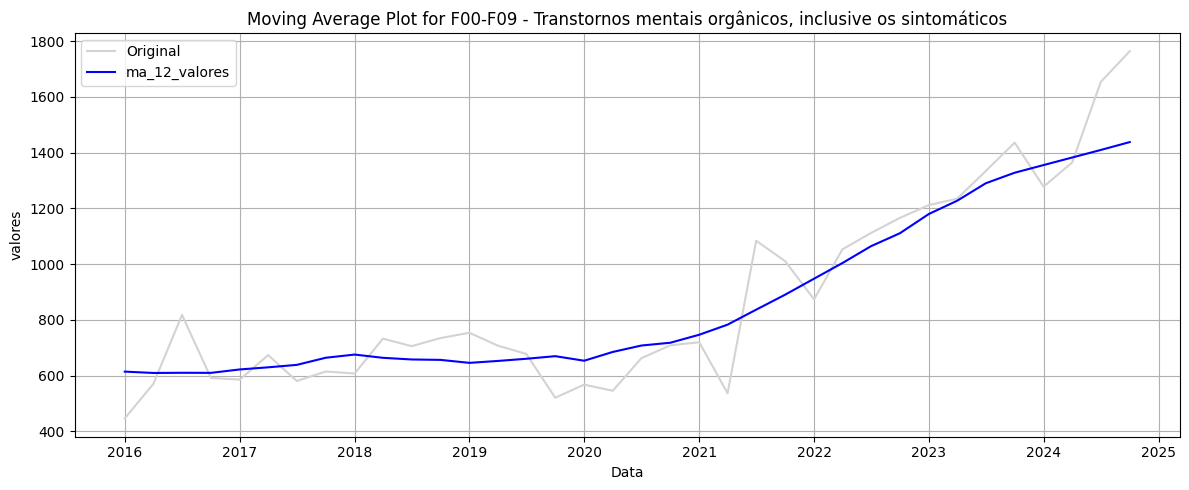

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



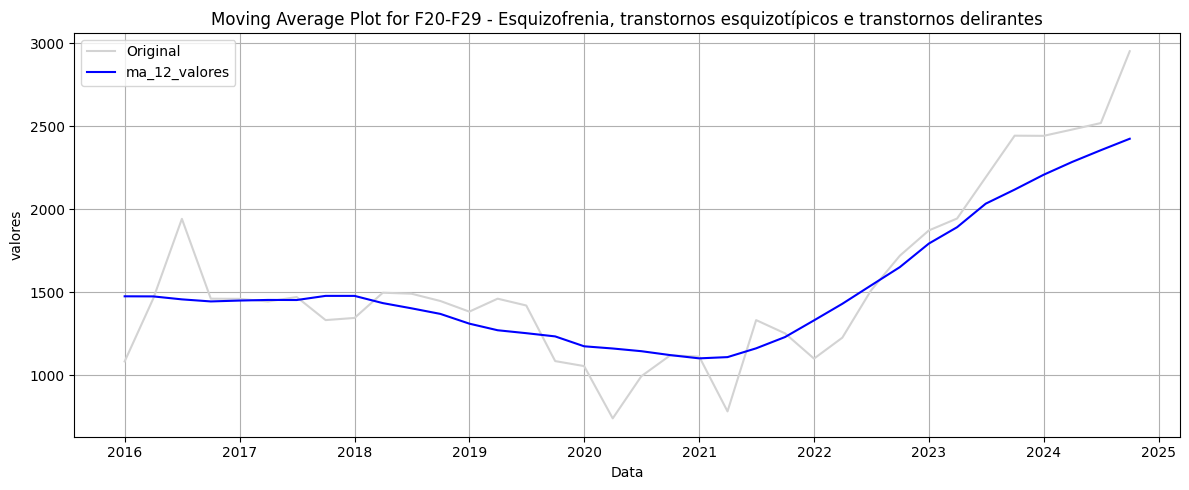

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



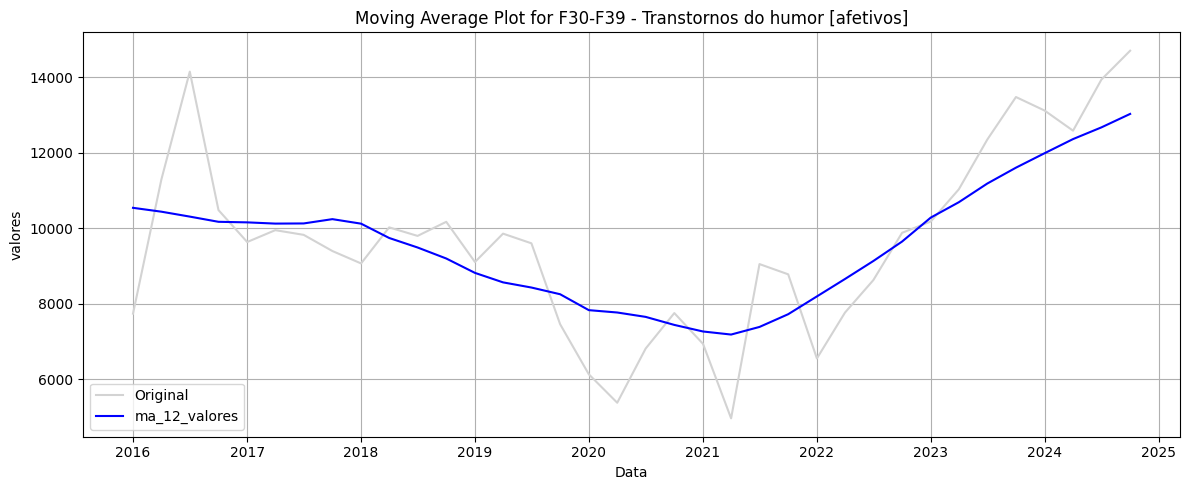

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



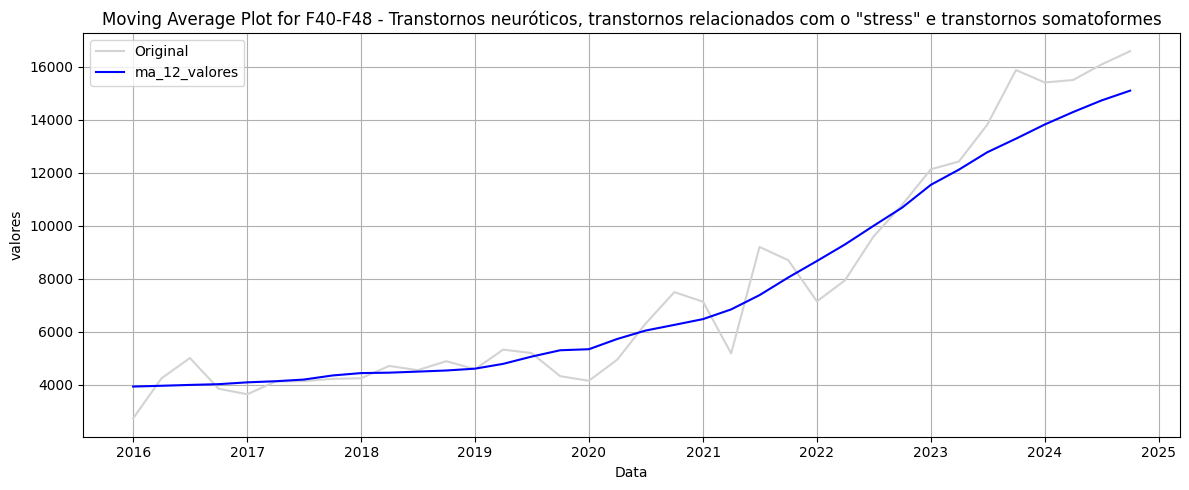

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



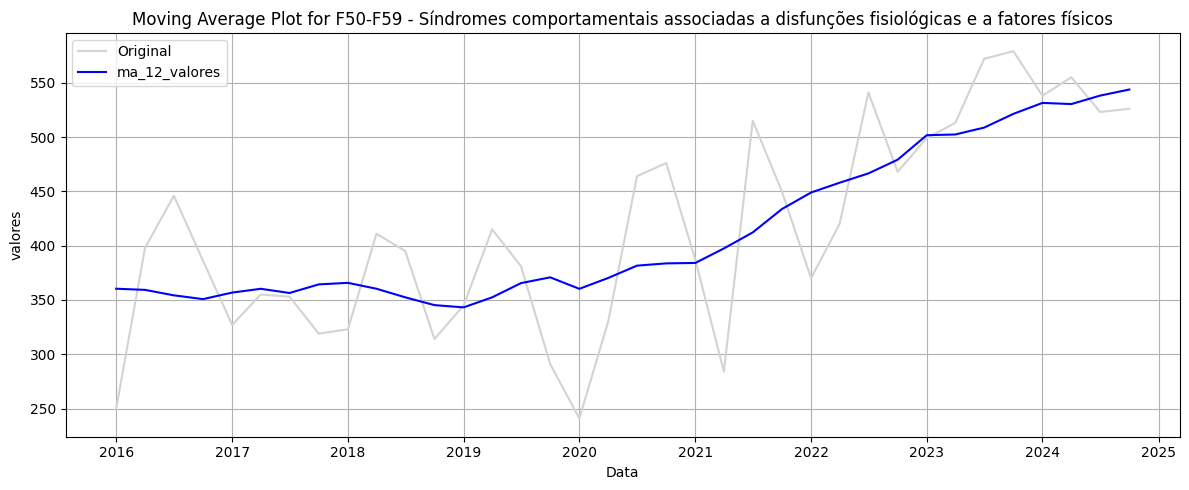

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



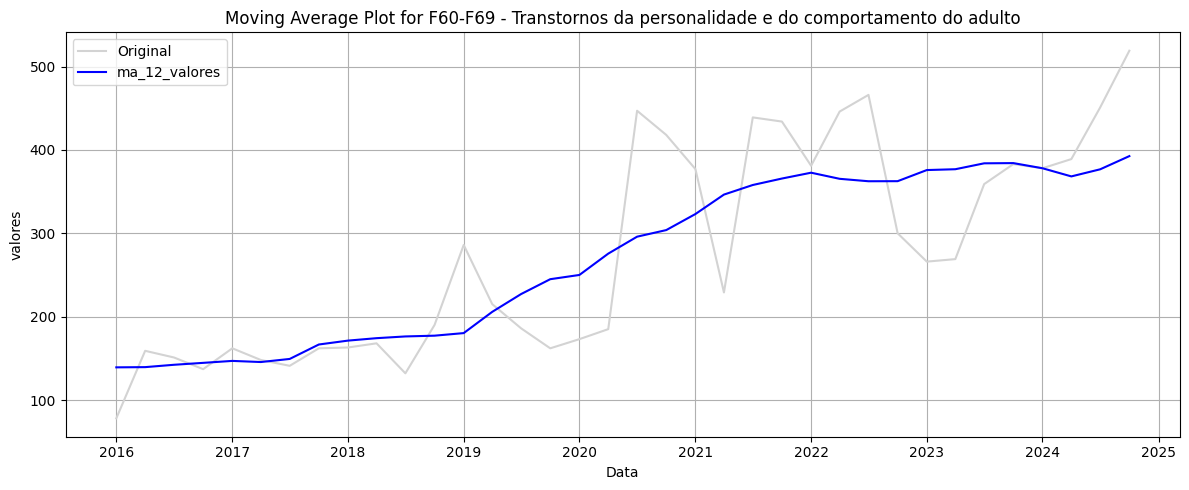

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



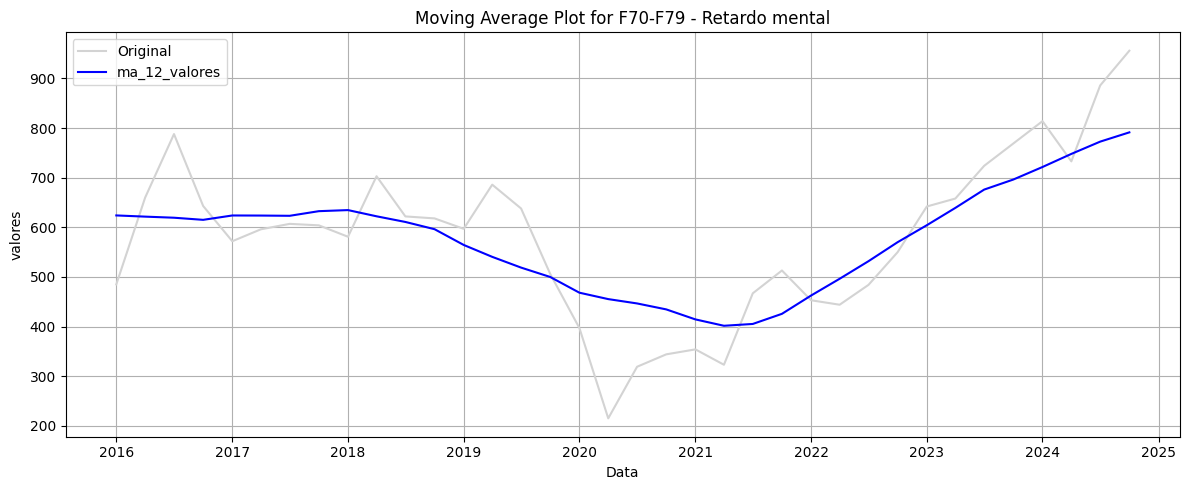

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



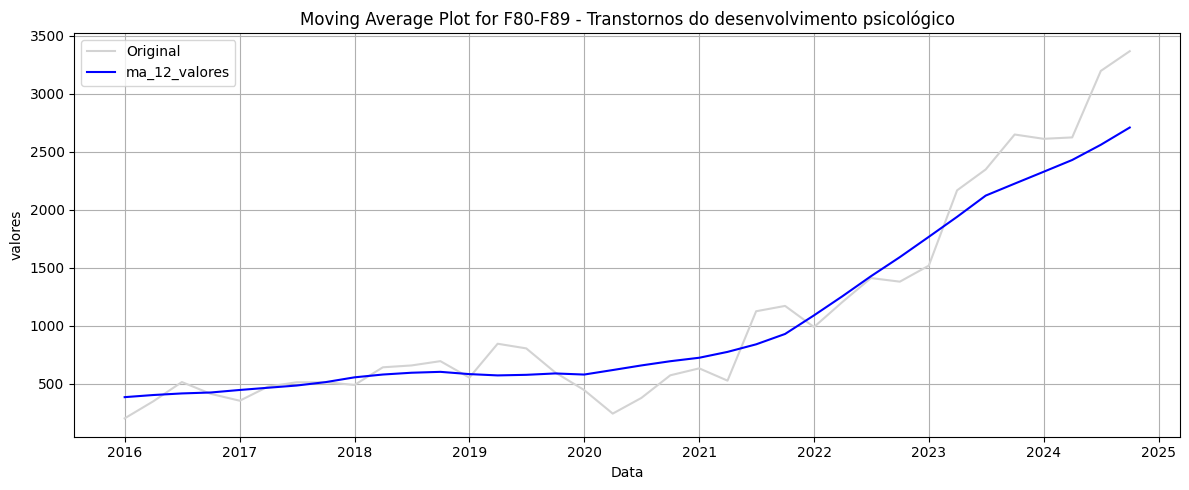

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



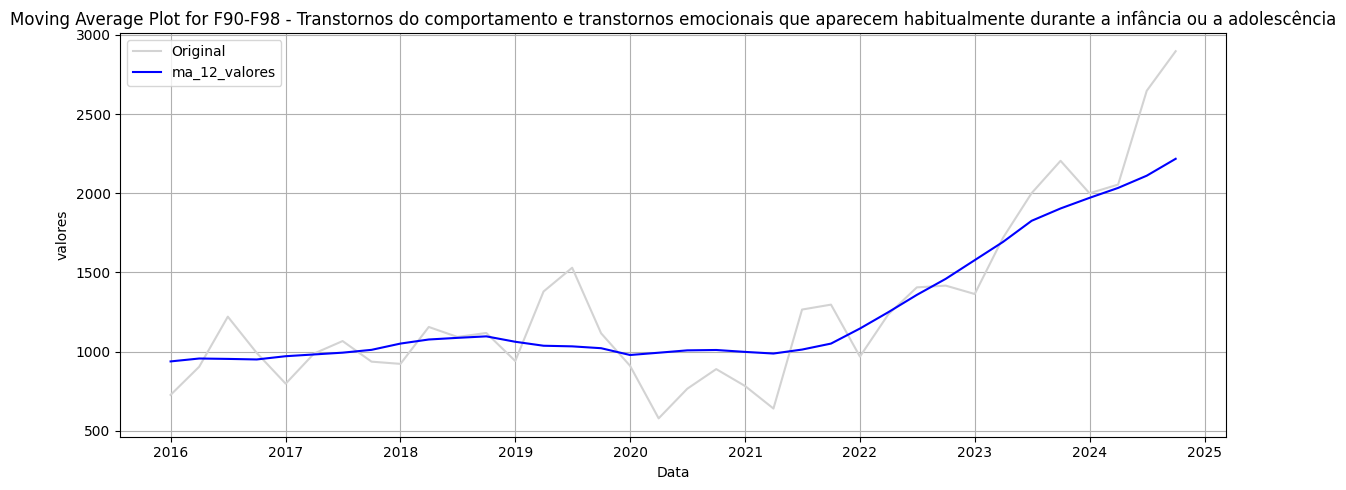

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



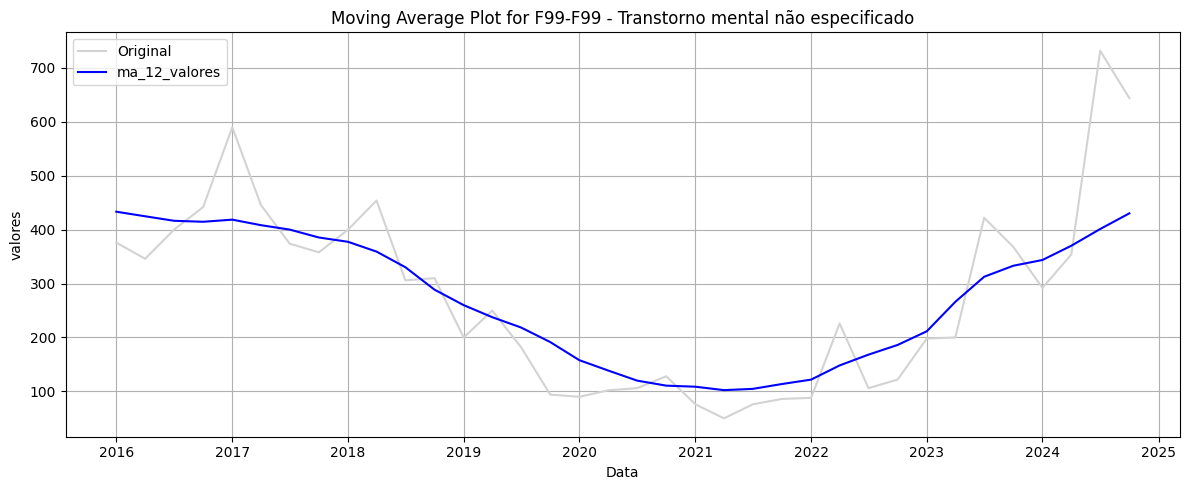

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



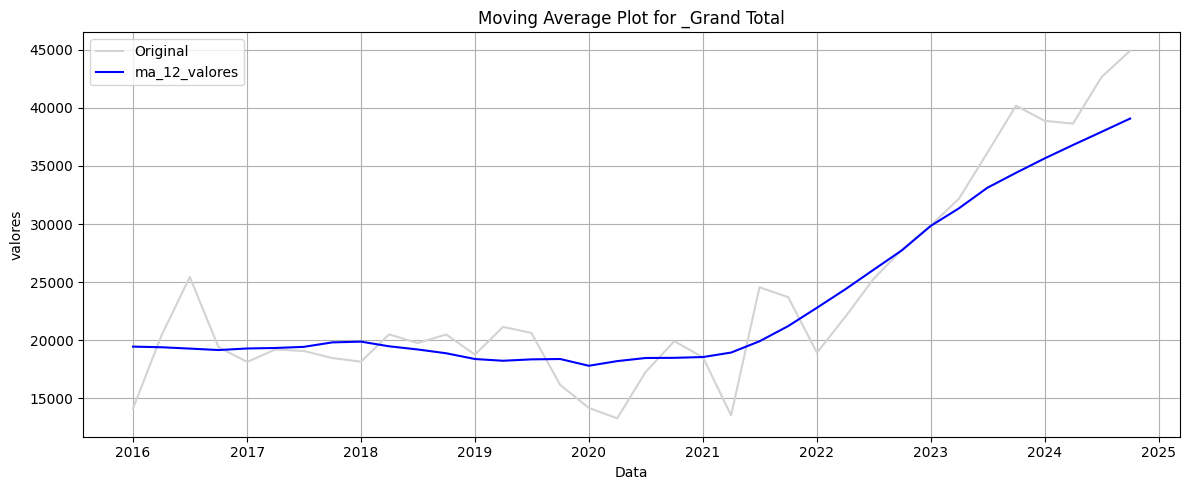

C:\Users\Lucas\AppData\Local\Temp\ipykernel_21520\595914539.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



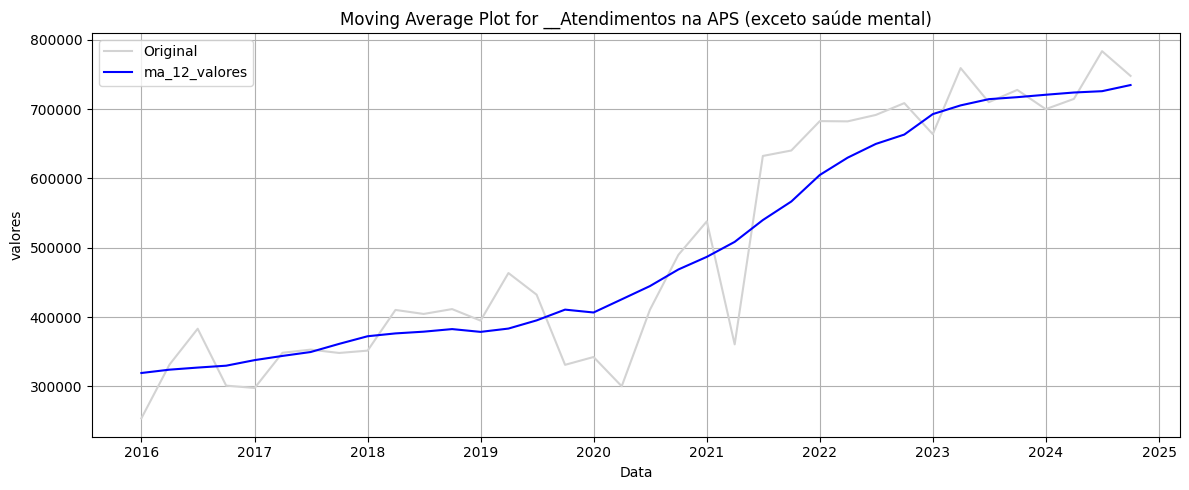

In [408]:
import matplotlib.pyplot as plt



moving_avg_pipe = Pipeline([
	('moving_average', MovingAverageTransformer(window=MOVING_WINDOW, prefix='ma', center=True)),
	]
	)

def plot_moving_average(df, column, ma_column=None, title='Moving Average Plot', date_column='date'):
    """
    Plota a série temporal original junto com a média móvel.

    df: DataFrame contendo os dados
    column: nome da coluna original
    ma_column: nome da coluna da média móvel (se None, assume padrão de 'ma_{window}_{column}')
    title: título do gráfico
    date_column: nome da coluna de data
    """
    if ma_column is None:
        ma_column = [col for col in df.columns if col.startswith('ma_') and col.endswith(column)]
        if ma_column:
            ma_column = ma_column[0]
        else:
            raise ValueError("Média móvel não encontrada. Verifique o nome da coluna.")

    df[date_column] = pd.to_datetime(df[date_column])  # Ensure datetime format

    plt.figure(figsize=(12, 5))
    plt.plot(df[date_column], df[column], label='Original', color='lightgray')
    plt.plot(df[date_column], df[ma_column], label=f'{ma_column}', color='blue')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for var in RegressionDF[VARIABLE_COLUMN_NAME].unique():
		var_df = RegressionDF[RegressionDF[VARIABLE_COLUMN_NAME] == var]
		#var_df = var_df.sort_values(by = INDEPENDENT_VAR, ascending=False)
		#print(var_df)
		#var_df = moving_avg_pipe.fit_transform(var_df)


		plot_moving_average(var_df, column=DEPENDENT_VAR, ma_column=f'ma_{MOVING_WINDOW}_valores', title=f'Moving Average Plot for {var}')



# Get Period Date Map and Dummies Period Indexes

In [409]:

PERIOD_DATE_MAP = pipe.named_steps['period_index_adder'].period_date_mapping
PERIOD_DATE_MAP

{Timestamp('2016-01-01 00:00:00'): 1,
 Timestamp('2016-04-01 00:00:00'): 2,
 Timestamp('2016-07-01 00:00:00'): 3,
 Timestamp('2016-10-01 00:00:00'): 4,
 Timestamp('2017-01-01 00:00:00'): 5,
 Timestamp('2017-04-01 00:00:00'): 6,
 Timestamp('2017-07-01 00:00:00'): 7,
 Timestamp('2017-10-01 00:00:00'): 8,
 Timestamp('2018-01-01 00:00:00'): 9,
 Timestamp('2018-04-01 00:00:00'): 10,
 Timestamp('2018-07-01 00:00:00'): 11,
 Timestamp('2018-10-01 00:00:00'): 12,
 Timestamp('2019-01-01 00:00:00'): 13,
 Timestamp('2019-04-01 00:00:00'): 14,
 Timestamp('2019-07-01 00:00:00'): 15,
 Timestamp('2019-10-01 00:00:00'): 16,
 Timestamp('2020-01-01 00:00:00'): 17,
 Timestamp('2020-04-01 00:00:00'): 18,
 Timestamp('2020-07-01 00:00:00'): 19,
 Timestamp('2020-10-01 00:00:00'): 20,
 Timestamp('2021-01-01 00:00:00'): 21,
 Timestamp('2021-04-01 00:00:00'): 22,
 Timestamp('2021-07-01 00:00:00'): 23,
 Timestamp('2021-10-01 00:00:00'): 24,
 Timestamp('2022-01-01 00:00:00'): 25,
 Timestamp('2022-04-01 00:00:00'):

In [410]:
def find_idx_from_date(target_date, args, period_date_map=PERIOD_DATE_MAP):
    """
    Finds the 'periodo' (index) corresponding to a given datetime in the PERIOD_DATE_MAP.

    Args:
        target_date (str or datetime): The target date to search for (e.g., '2020-01-01').
        period_date_map (dict): The PERIOD_DATE_MAP containing period-to-date mappings.

    Returns:
        int: The 'periodo' (index) corresponding to the target date, or None if not found.
    """
    # Ensure the target_date is a datetime object and normalize to quarter-end
    if isinstance(target_date, str):
        target_date = pd.to_datetime(target_date)
    if args['FrequencyDateGroup'] == 'Q' or args['FrequencyDateGroup'] == 'QE':
        target_date = target_date + pd.offsets.QuarterEnd(0)

    # Iterate through the PERIOD_DATE_MAP to find the matching period
    for date, period in period_date_map.items():
        if isinstance(date, str):
            date = pd.to_datetime(date)
        if args['FrequencyDateGroup'] == 'Q' or args['FrequencyDateGroup'] == 'QE':
            date = date + pd.offsets.QuarterEnd(0) # Normalize to quarter-end
        if date == target_date:
            return period - 1

    return None


def find_date_from_idx(target_idx, args, period_date_map=PERIOD_DATE_MAP):
    """
    Finds the date corresponding to a given 'periodo' (index) in the PERIOD_DATE_MAP.

    Args:
        target_idx (int): The target index to search for (e.g., 1, 2, 3).
        period_date_map (dict): The PERIOD_DATE_MAP containing period-to-date mappings.

    Returns:
        datetime or None: The date corresponding to the target index, or None if not found.
    """
    # Iterate through the PERIOD_DATE_MAP to find the matching index
    for date, period in period_date_map.items():
        if period == target_idx:
            date = pd.to_datetime(date) if isinstance(date, str) else date
            date = date + pd.offsets.QuarterEnd(0) if args['FrequencyDateGroup'] == 'Q' or args['FrequencyDateGroup'] == 'QE' else date
            return date
    return None

In [411]:
DummyIndexes = {}

# Iterate over DUMMY_ARGS to calculate and store indexes
for dummy_name, config in DUMMY_ARGS.items():
    start_date = config.get("start_date")
    end_date = config.get("end_date")

    print(dummy_name, config)
    # Calculate indexes using find_idx_from_date
    start_idx = find_idx_from_date(start_date, PREPROCESSOR_ARGS, PERIOD_DATE_MAP) if start_date else None
    end_idx = find_idx_from_date(end_date, PREPROCESSOR_ARGS, PERIOD_DATE_MAP) if end_date else None

    # Store the indexes in the table
    DummyIndexes[dummy_name] = {
        "start_index": start_idx,
        "end_index": end_idx
    }
DummyIndexes



teste_remove_outlier {'start_date': '2019-10-01', 'end_date': '2019-12-01'}
Pandemia_Step {'start_date': '2020-01-01', 'end_date': '2021-12-01', 'exclude_ranges': [('2020-03-01', '2020-07-01'), ('2021-04-01', '2021-05-01')]}
Choque_Inicial {'start_date': '2020-03-01', 'end_date': '2020-07-01'}
Pandemia_Trend {'start_date': '2020-01-01', 'end_date': '2021-12-01', 'exclude_ranges': [('2020-03-01', '2020-07-01'), ('2021-04-01', '2021-05-01')], 'add_time_trend': True, 'keep_period_index': False}
Lockdown_2021 {'start_date': '2021-04-01', 'end_date': '2021-05-01'}
Step_PosPandemia {'start_date': '2022-01-01', 'end_date': '2024-12-01', 'exclude_ranges': [], 'plot': False, 'step': True}
Trend_PosPandemia {'start_date': '2022-01-01', 'end_date': '2024-12-01', 'exclude_ranges': [], 'plot': True, 'add_time_trend': True, 'keep_period_index': False, 'step': False}


{'teste_remove_outlier': {'start_index': 15, 'end_index': None},
 'Pandemia_Step': {'start_index': 16, 'end_index': None},
 'Choque_Inicial': {'start_index': None, 'end_index': 18},
 'Pandemia_Trend': {'start_index': 16, 'end_index': None},
 'Lockdown_2021': {'start_index': 21, 'end_index': None},
 'Step_PosPandemia': {'start_index': 24, 'end_index': None},
 'Trend_PosPandemia': {'start_index': 24, 'end_index': None}}

# Exploration


In [412]:
main_regrdf = RegressionDF
main_regrdf[VARIABLE_COLUMN_NAME]
main_regrdf

date  \
variavel                                                            
F00-F09 - Transtornos mentais orgânicos, inclus... 431 2016-01-01   
                                                   396 2016-04-01   
                                                   430 2016-07-01   
                                                   429 2016-10-01   
                                                   426 2017-01-01   
...                                                           ...   
__Atendimentos na APS (exceto saúde mental)        13  2023-10-01   
                                                   22  2024-01-01   
                                                   34  2024-04-01   
                                                   27  2024-07-01   
                                                   0   2024-10-01   

                                                                                                 variavel  \
variavel                                                                                                    
F00-F09 - Transtornos mentais orgânicos, inclus... 431  F00-F09 - Transtornos mentais orgânicos, inclu...   
                                                   396  F00-F09 - Transtornos mentais orgânicos, inclu...   
                                                   430  F00-F09 - Transtornos mentais orgânicos, inclu...   
                                                   429  F00-F09 - Transtornos mentais orgânicos, inclu...   
                                                   426  F00-F09 - Transtornos mentais orgânicos, inclu...   
...                                                                                                   ...   
__Atendimentos na APS (exceto saúde mental)        13         __Atendimentos na APS (exceto saúde mental)   
                                                   22         __Atendimentos na APS (exceto saúde mental)   
                                                   34         __Atendimentos na APS (exceto saúde mental)   
                                                   27         __Atendimentos na APS (exceto saúde mental)   
                                                   0          __Atendimentos na APS (exceto saúde mental)   

                                                        valores  periodo  \
variavel                                                                   
F00-F09 - Transtornos mentais orgânicos, inclus... 431      447        1   
                                                   396      571        2   
                                                   430      818        3   
                                                   429      592        4   
                                                   426      586        5   
...                                                         ...      ...   
__Atendimentos na APS (exceto saúde mental)        13    727668       32   
                                                   22    699921       33   
                                                   34    714682       34   
                                                   27    783513       35   
                                                   0     747870       36   

                                                        teste_remove_outlier  \
variavel                                                                       
F00-F09 - Transtornos mentais orgânicos, inclus... 431                     0   
                                                   396                     0   
                                                   430                     0   
                                                   429                     0   
                                                   426                     0   
...                                                                      ...   
__Atendimentos na APS (exceto saúde mental)        13                      0   
                                    

In [413]:
from statsmodels.api import OLS
from statsmodels.tools.tools import add_constant
import pandas as pd
from scipy.stats import f

def chow_test(data, split_point, dependent_var, independent_vars):
    """
    Realiza o teste de Chow para verificar mudanças estruturais em um modelo de regressão.

    Args:
        data (pd.DataFrame): DataFrame contendo os dados.
        split_point (int): Ponto de divisão para o teste de Chow.
        dependent_var (str): Nome da variável dependente.
        independent_vars (list): Lista de nomes das variáveis independentes.

    Returns:
        dict: Resultados do teste de Chow contendo os valores F e p.
    """
    # Dividir os dados em dois subconjuntos
    data1 = data[data['periodo'] <= split_point]
    data2 = data[data['periodo'] > split_point]

    # Ajustar os modelos para cada subconjunto
    X1 = add_constant(data1[independent_vars])
    y1 = data1[dependent_var]
    model1 = OLS(y1, X1).fit()

    X2 = add_constant(data2[independent_vars])
    y2 = data2[dependent_var]
    model2 = OLS(y2, X2).fit()

    # Ajustar o modelo para o conjunto completo
    X_full = add_constant(data[independent_vars])
    y_full = data[dependent_var]
    model_full = OLS(y_full, X_full).fit()

    # Calcular os graus de liberdade
    k = len(independent_vars) + 1  # Número de parâmetros (incluindo o intercepto)
    n1 = len(data1)
    n2 = len(data2)
    n = n1 + n2

    # Calcular a soma dos quadrados dos resíduos
    RSS1 = model1.ssr
    RSS2 = model2.ssr
    RSS_full = model_full.ssr

    # Calcular o valor F
    F = ((RSS_full - (RSS1 + RSS2)) / k) / ((RSS1 + RSS2) / (n - 2 * k))

    # Calcular o p-valor
    p_value = 1 - f.cdf(F, k, n - 2 * k)

    return {"F-statistic": F, "p-value": p_value}


if True:
    chow_results = {}
    split_point = find_idx_from_date(POS_PANDEMIA_START_DATE, PREPROCESSOR_ARGS)  # Exemplo: ponto de divisão para o teste de Chow
    dependent_var = DEPENDENT_VAR
    independent_vars = [INDEPENDENT_VAR] #+ [key for key in DUMMY_ARGS.keys()]
    for variable in main_regrdf[VARIABLE_COLUMN_NAME].unique():
        variable_data = main_regrdf[main_regrdf[VARIABLE_COLUMN_NAME] == variable]
        result = chow_test(variable_data, split_point, dependent_var, independent_vars)
        chow_results[variable] = result
    # Converter os resultados em um DataFrame para visualização
    chow_results_df = pd.DataFrame(chow_results).T
    chow_results_df.columns = ["F-statistic", "p-value"]
    chow_results_df['p-value'] = chow_results_df['p-value'].round(8)
    print(chow_results_df)

                                                    F-statistic       p-value
F00-F09 - Transtornos mentais orgânicos, inclus...    23.538668  5.200000e-07
F20-F29 - Esquizofrenia, transtornos esquizotíp...    77.601980  0.000000e+00
F30-F39 - Transtornos do humor [afetivos]             37.719693  0.000000e+00
F40-F48 - Transtornos neuróticos, transtornos r...    49.432381  0.000000e+00
F50-F59 - Síndromes comportamentais associadas ...     2.969069  6.564223e-02
F60-F69 - Transtornos da personalidade e do com...     0.972423  3.890613e-01
F70-F79 - Retardo mental                              35.257707  1.000000e-08
F80-F89 - Transtornos do desenvolvimento psicol...    94.138820  0.000000e+00
F90-F98 - Transtornos do comportamento e transt...    36.897033  0.000000e+00
F99-F99 - Transtorno mental não especificado          52.415510  0.000000e+00
_Grand Total                                          58.013282  0.000000e+00
__Atendimentos na APS (exceto saúde mental)            8.089587 

In [414]:
### TODO: make the knots per variable
### TODO: remove the bumps/step_dummies before testing

pwmodel = pwlf.PiecewiseLinFit(main_regrdf[INDEPENDENT_VAR].values,main_regrdf[DEPENDENT_VAR].values)
knots = pwmodel.fit(2)
print(knots)
for knot in knots:
    print(find_date_from_idx(np.round(knot), PREPROCESSOR_ARGS, PERIOD_DATE_MAP))

[ 1.         17.55955653 36.        ]
2016-01-01 00:00:00
2020-04-01 00:00:00
2024-10-01 00:00:00


In [415]:
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro, normaltest, jarque_bera
import statsmodels.api as sm

def analyze_time_series(df: pd.DataFrame, variable_col: str, date_col: str, value_col: str):
    """
    Analyzes a melted DataFrame for heteroscedasticity, distribution, and autocorrelation.

    Parameters:
        df (pd.DataFrame): Melted DataFrame with columns for variable, date, and value.
        variable_col (str): Column name for the variable identifier.
        date_col (str): Column name for the date.
        value_col (str): Column name for the value.

    Returns:
        dict: A dictionary with analysis results for each variable.
    """
    results = {}

    for variable in df[variable_col].unique():
        # Filter data for the current variable
        variable_data = df[df[variable_col] == variable].sort_values(by=date_col)
        y = variable_data[value_col].values
        x = np.arange(len(y))  # Time index as independent variable

        # Add constant for regression
        X = sm.add_constant(x)

        # Fit OLS model
        model = sm.OLS(y, X).fit()

        # Heteroscedasticity tests
        bp_test = het_breuschpagan(model.resid, X)
        bp_pvalue = bp_test[1]

        # Normality tests
        shapiro_test = shapiro(model.resid)
        shapiro_pvalue = shapiro_test.pvalue

        jb_test = jarque_bera(model.resid)
        jb_pvalue = jb_test[1]

        dagostino_test = normaltest(model.resid)
        dagostino_pvalue = dagostino_test.pvalue

        # Autocorrelation tests
        dw_stat = durbin_watson(model.resid)
        ljungbox_test = acorr_ljungbox(model.resid, lags=[10], return_df=True)
        ljungbox_pvalue = ljungbox_test['lb_pvalue'].iloc[0]

        # Store results
        results[variable] = {
            "Heteroscedasticity (Breusch-Pagan)": bp_pvalue,
            "Normality (Shapiro-Wilk)": shapiro_pvalue,
            "Normality (Jarque-Bera)": jb_pvalue,
            "Normality (D'Agostino)": dagostino_pvalue,
            "Autocorrelation (Durbin-Watson)": dw_stat,
            "Autocorrelation (Ljung-Box)": ljungbox_pvalue,
        }

    return results

explorationresults = analyze_time_series(main_regrdf, VARIABLE_COLUMN_NAME, DATE_NAME, DEPENDENT_VAR)
explorationresultsDF = pd.DataFrame(explorationresults).T
explorationresultsDF

,Heteroscedasticity (Breusch-Pagan),Normality (Shapiro-Wilk),Normality (Jarque-Bera),Normality (D'Agostino),Autocorrelation (Durbin-Watson),Autocorrelation (Ljung-Box)
"F00-F09 - Transtornos mentais orgânicos, inclusive os sintomáticos",0.394899,0.106954,0.868355,0.644248,0.599941,1.861455e-06
"F20-F29 - Esquizofrenia, transtornos esquizotípicos e transtornos delirantes",0.052259,0.603315,0.767008,0.828379,0.267150,1.087368e-12
F30-F39 - Transtornos do humor [afetivos],0.371243,0.967356,0.910598,0.992927,0.428287,1.377146e-08
"F40-F48 - Transtornos neuróticos, transtornos relacionados com o ""stress"" e transtornos somatoformes",0.186079,0.622387,0.588330,0.464093,0.343390,1.389249e-10
F50-F59 - Síndromes comportamentais associadas a disfunções fisiológicas e a fatores físicos,0.539814,0.372187,0.332504,0.211465,1.314904,1.524139e-01
F60-F69 - Transtornos da personalidade e do comportamento do adulto,0.062003,0.280358,0.431063,0.388837,1.140935,1.048381e-02
F70-F79 - Retardo mental,0.104808,0.433385,0.646183,0.665406,0.286601,3.796048e-10
F80-F89 - Transtornos do desenvolvimento psicológico,0.006449,0.390949,0.688509,0.680373,0.190719,3.552414e-12
F90-F98 - Transtornos do comportamento e transtornos emocionais que aparecem habitualmente durante a infância ou a adolescência,0.019154,0.731937,0.931704,0.779022,0.418693,1.200133e-06
F99-F99 - Transtorno mental não especificado,0.024754,0.009271,0.088782,0.046158,0.349225,8.974967e-09


# Define Processors

In [416]:
class RegressionProcessor:
    def __init__(
        self,
        data,
        formula,
        model=None,
        find_best_rho=False,
        find_best_rho_args={
            'start': -1.0,
            "stop": 1.0,
            'step': 0.05,
            'criterio': 'aic',
        },
        rho=None,
        cov_type=None,
        cov_kwargs=None,
        iterative_fit=False,  # New argument to enable iterative fitting
        max_iterations=100,  # Maximum iterations for iterative fitting
    ):
        self.data = data
        self.formula = formula
        self.model = model
        self.rho = rho
        self.cov_type = cov_type
        self.cov_kwargs = cov_kwargs
        self.find_best_rho = find_best_rho
        self.find_best_rho_args = find_best_rho_args
        self.iterative_fit = iterative_fit
        self.max_iterations = max_iterations
        self.results = None

    def fit(self, rho=None):
        # Fit the regression model using the specified formula and data
        if self.find_best_rho:
            best_rho = 1.0
            best_criterion_value = np.inf
            model = None
            results = None
            for rho in np.arange(
                self.find_best_rho_args['start'],
                self.find_best_rho_args['stop'],
                self.find_best_rho_args['step']
            ):
                test_model = self.model(self.formula, data=self.data, rho=rho)
                if self.iterative_fit and hasattr(test_model, "iterative_fit"):
                    test_results = test_model.iterative_fit(
                        maxiter=self.max_iterations,
                        cov_type=self.cov_type,
                        cov_kwds=self.cov_kwargs,
                    )
                else:
                    test_results = test_model.fit(
                        cov_type=self.cov_type,
                        cov_kwds=self.cov_kwargs,
                    )
                criterion_value = getattr(test_results, self.find_best_rho_args['criterio'])
                if criterion_value < best_criterion_value:
                    best_criterion_value = criterion_value
                    best_rho = rho
                    model = test_model
                    results = test_results
            self.rho = best_rho
            self.results = results
        else:
            if self.rho is not None:
                model = self.model(self.formula, data=self.data, rho=rho)
            else:
                model = self.model(self.formula, data=self.data)

            # Use iterative fitting if enabled and supported
            if self.iterative_fit and hasattr(model, "iterative_fit"):
                self.results = model.iterative_fit(
                    maxiter=self.max_iterations,
                    cov_type=self.cov_type,
                    cov_kwds=self.cov_kwargs,
                )
            else:
                self.results = model.fit(
                    cov_type=self.cov_type,
                    cov_kwds=self.cov_kwargs,
                )

In [417]:
class ARIMAXRegressor:
	def __init__(self, data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), dummy_args=None):
		self.data = data
		self.order = order
		self.seasonal_order = seasonal_order
		self.dummy_args = dummy_args or {}
		self.model = None
		self.results = None

	def fit(self):
		exog = self._get_exog()
		endog = self.data[DEPENDENT_VAR]

		self.model = SARIMAX(
			endog=endog,
			exog=exog,
			order=self.order,
			seasonal_order=self.seasonal_order,
			enforce_stationarity=False,
			enforce_invertibility=False
		)
		self.results = self.model.fit(disp=False)
		return self

	def predict(self, data):
		exog = self._get_exog(data)
		return self.results.predict(start=data.index[0], end=data.index[-1], exog=exog)

	def _get_exog(self, data=None):
		data = data or self.data
		return data[list(self.dummy_args.keys())]

In [424]:
class VariableProcessor:
    def __init__(
        self,
        df,
        processor_args,
        processor,
        evaluate = False,
        test_size=0.2,
        random_state=42,

    ):
        self.df = df
        self.results = {}
        self.processor_args = processor_args
        self.processor = processor
        self.evaluate = evaluate
        self.evaluation_results = {}
        self.test_size = test_size
        self.random_state = random_state


    def adjusted_r2(self, r2, n, p):
        """Calcula o R² ajustado."""
        return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    def process_variables(self):
        # Process each variable in the DataFrame
        for variable in self.df[VARIABLE_COLUMN_NAME].unique():
            variable_data = self.df[self.df[VARIABLE_COLUMN_NAME] == variable].sort_values(by=DATE_NAME)
            variable_data = variable_data.reset_index(drop=True)

            if self.processor == Ridge:
                X = variable_data.drop(columns=[DEPENDENT_VAR, VARIABLE_COLUMN_NAME, DATE_NAME])  # Features (X)
                y = variable_data[DEPENDENT_VAR]  # Target (y)

                # Instantiate the Ridge model with the provided arguments
                processor = self.processor(**self.processor_args)
                processor.fit(X, y)
            else:
                processor = self.processor(data=variable_data, **self.processor_args)
                processor.fit()
                
                self.results[variable] = processor.results




            # Split into train and test
            if self.evaluate:
                train_data, test_data = train_test_split(
                    variable_data, test_size=self.test_size, random_state=self.random_state, shuffle=False
                )

                # Store results for train and test
                train_predictions = processor.results.predict(train_data)
                test_predictions = processor.results.predict(test_data)

                # Calculate metrics
                train_r2 = r2_score(train_data[DEPENDENT_VAR], train_predictions)
                test_r2 = r2_score(test_data[DEPENDENT_VAR], test_predictions)
                #n_train = len(train_data)
                #n_test = len(test_data)
                #p = len(processor.results.params) - 1
                train_mse = mean_squared_error(train_data[DEPENDENT_VAR], train_predictions)
                test_mse = mean_squared_error(test_data[DEPENDENT_VAR], test_predictions)

                #train_r2_adj = self.adjusted_r2(train_r2, n_train, p)
                #test_r2_adj = self.adjusted_r2(test_r2, n_test, p)

                evaluation_value = train_r2 - test_r2
                #evaluation_value_adj = train_r2_adj - test_r2_adj


                self.evaluation_results[variable] = {
                    #'Absolute Diff': absolute_difference,
                    'TrainMSE - TestMSE': train_mse - test_mse,
                    "Evaluation Value (r_train² - r_test²)": evaluation_value,
                    "Overfitting Risk": "High" if evaluation_value > 0.1 else "Low",
                    "Train R2": train_r2,
                    "Test R2": test_r2,
                    #"Evaluation Value (r_train_adj² - r_test_adj²)": evaluation_value_adj,
                    #"Overfitting Risk (adj_r2)": "High" if evaluation_value_adj > 0.1 else "Low",
                    #"Adj Train R2": train_r2_adj,
                    #"Adj Test R2": test_r2_adj,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                    "Processor Results": processor.results,
                    'splitted_data': {'train_data': train_data, 'test_data': test_data},
                }

        self.evaluation_results = pd.DataFrame(self.evaluation_results).T

        return self.results, self.evaluation_results

In [438]:
class RIDGE_VariableProcessor:
    def __init__(
        self,
        df,
        processor_args,
        processor,
        evaluate=False,
        test_size=0.2,
        random_state=42,
    ):
        self.df = df
        self.results = {}
        self.processor_args = processor_args
        self.processor = processor
        self.evaluate = evaluate
        self.evaluation_results = {}
        self.test_size = test_size
        self.random_state = random_state

    def process_variables(self):
        # Process each variable in the DataFrame
        for variable in self.df[VARIABLE_COLUMN_NAME].unique():
            variable_data = self.df[self.df[VARIABLE_COLUMN_NAME] == variable].sort_values(by=DATE_NAME)
            variable_data = variable_data.reset_index(drop=True)

            X = variable_data.drop(columns=[DEPENDENT_VAR, VARIABLE_COLUMN_NAME, DATE_NAME])  # Features (X)
            y = variable_data[DEPENDENT_VAR]  # Target (y)

            # Instantiate the Ridge model with the provided arguments
            processor = self.processor(**self.processor_args)
            processor.fit(X, y)

            # Map coefficients to their corresponding feature names
            coef_dict = dict(zip(X.columns, processor.coef_))

            self.results[variable] = {
                'Coefficients': coef_dict,  # Coefficients with feature labels
                'Intercept': processor.intercept_,
                'Model': processor,  # You can also store the entire fitted model
            }

# Define Exporter

In [ ]:
def export_results(results, output_path, processor_args, preprocessor_args, output_gsheet = None):
    """
    Exports the regression results and metadata to an Excel file.

    Args:
        results (dict): Dictionary containing regression results.
        output_path (str): Path to the output Excel file.
        processor_args (dict): Dictionary containing processor arguments.
        preprocessor_args (dict): Dictionary containing preprocessor arguments.
    """
    def extract_durbin_watson_from_summary(result):
        summary_text = result.summary().as_text()
        for line in summary_text.split('\n'):
            if "Durbin-Watson" in line:
                return float(line.split()[-1])  # Extract the last value in the line
        return None  # Return None if not found


    def try_create_worksheet(output_gsheet, title: str) -> None:
        if output_gsheet:
            try:
                output_gsheet.worksheet(title)
            except gspread.exceptions.WorksheetNotFound:
                output_gsheet.add_worksheet(title=title, rows="100", cols="20")


    stats_data = []
    coefficients_data = []

    for variable, result in results.items():
        # Extract coefficients
        coefficients = result.params
        coef_row = {"Variable": variable}
        for coef_name, coef_value in coefficients.items():
            coef_row[f"{coef_name}__Value"] = round(coef_value, 7)
            coef_row[f"{coef_name}__Value_%_intercept"] = coef_value/result.params['Intercept']*100
            coef_row[f"{coef_name}__P-Value"] = round(result.pvalues.get(coef_name, np.nan), 7)
            coef_row[f"{coef_name}__Std Err"] = round(result.bse.get(coef_name, np.nan), 7)
            coef_row[f"{coef_name}__Significant"] = result.pvalues.get(coef_name, np.nan) < 0.05  # At 5% significance
        coefficients_data.append(coef_row)

        # Extract other statistics
        stats_data.append({
            "Variable": variable,
            "R-Squared": round(result.rsquared, 7),
            "Adjusted R-Squared": round(result.rsquared_adj, 7),
            "Durbin-Watson": round(extract_durbin_watson_from_summary(result), 7),
            "AIC": round(result.aic, 7),
            "BIC": round(result.bic, 7),
            "Number of Observations": result.nobs,
            "F-Value": round(result.fvalue, 7) if result.fvalue is not None else np.nan,
            "F P-Value": round(result.f_pvalue, 7) if result.f_pvalue is not None else np.nan,
            "Log-Likelihood": round(result.llf, 7),
            "Condition Number": round(result.condition_number, 7) if result.condition_number is not None else np.nan
        })

    # Convert to DataFrames
    coefficients_df = pd.DataFrame(coefficients_data).set_index("Variable")
    stats_df = pd.DataFrame(stats_data).set_index("Variable")

    # Prepare metadata
    metadata = {
        "Processor Args": [str(processor_args)],
        "Preprocessor Args": [str(preprocessor_args)]
    }
    metadata_df = pd.DataFrame(metadata)

    # Write to gsheet
    if output_gsheet is not None:
        for title, clean_df, include_index in [
            ("Coefficients", coefficients_df, True),
            ("Statistics", stats_df, True),
            ("Metadata", metadata_df, False)
        ]:
            try_create_worksheet(title=title, output_gsheet=output_gsheet)
            ws = output_gsheet.worksheet(title)
            ws.clear()
            set_with_dataframe(ws, clean_df, include_index=include_index)
    # Write to Excel
    else:
       file_exists = os.path.exists(output_path)

               # Attempt to open file and catch PermissionError if the file is open elsewhere
       if file_exists:
           while True:
               try:
                   with pd.ExcelWriter(output_path) as writer:
                       # Write coefficients to one sheet
                       coefficients_df.to_excel(writer, sheet_name="Coefficients")

                       # Write other stats to another sheet
                       stats_df.to_excel(writer, sheet_name="Statistics")

                       # Write metadata to another sheet
                       metadata_df.to_excel(writer, sheet_name="Metadata", index=False)
                   # Load the workbook to apply formatting
                   workbook = load_workbook(output_path)
                   if "Residuals" not in workbook.sheetnames:
                       workbook.create_sheet("Residuals")
                       residuals_sheet = workbook["Residuals"]

                   # Plot residuals for each variable and add them to the Residuals sheet
                   for idx, (variable, result) in enumerate(results.items(), start=1):
                       # Create a plot of residuals
                       plt.figure(figsize=(6, 4))
                       plt.scatter(range(len(result.resid)), result.resid, alpha=0.7)
                       plt.axhline(0, color="red", linestyle="--", linewidth=1)
                       plt.title(f"Residuals for {variable}")
                       plt.xlabel("Observation")
                       plt.ylabel("Residuals")
                       plt.tight_layout()

                       # Save the plot to a BytesIO object
                       img_data = BytesIO()
                       plt.savefig(img_data, format="png")
                       plt.close()
                       img_data.seek(0)

                       # Add the image to the Excel sheet
                       img = Image(img_data)
                       img.anchor = f"A{idx * 20}"  # Adjust the position of the image
                       residuals_sheet.add_image(img)

                   for sheet_name in ["Coefficients", "Statistics", "Metadata"]:
                       if sheet_name in workbook.sheetnames:
                           sheet = workbook[sheet_name]

                           # Enable text wrapping and adjust row heights
                           for row in sheet.iter_rows():
                               for cell in row:
                                   cell.alignment = Alignment(wrap_text=True)  # Enable text wrapping
                               # Adjust row height
                               sheet.row_dimensions[row[0].row].height = 25  # Set row height to 25 (adjust as needed)

                   # Save the formatted workbook
                   workbook.save(output_path)
                   break  # Exit the loop if writing succeeds
               except PermissionError:
                   #logger.warning(f"File '{output_path}' is currently open. Please close the file and press Enter to try again.")
                   input("Press Enter after closing the file...")
                   time.sleep(5)  # Optional: wait before retrying


# EXEC --- Instantiate Processor and Process/Export

In [ ]:
processor_args = PROCESSOR_ARGS
processor_args = {'alpha': 1.0}
exog_df = pd.DataFrame({key: DUMMY_ARGS[key] for key in DUMMY_ARGS})

'''
variable_processor = VariableProcessor(
    df = RegressionDF,
    processor_args = processor_args,
    processor = RegressionProcessor,#ARIMAXRegressor, #
)
'''

variable_processor = RIDGE_VariableProcessor(
    df = RegressionDF,
    processor_args = processor_args,
    processor = Ridge,
)
variable_processor.process_variables()
results = variable_processor.results


In [ ]:


def display_variables_results_RIDGE(results):
    # Initialize an empty list to store the data
    data = []

    # Iterate through the results and extract the required information
    for variable in results:
        model = results[variable]['Model']
        coef_dict = dict(zip(model.feature_names_in_, model.coef_))  # Map coefficients to feature names
        data.append({
            "Variable": variable,
            "Intercept": model.intercept_,
            "Alpha": getattr(model, 'alpha', None),  # Use getattr to handle cases where alpha might not exist
            **coef_dict  # Unpack the coefficients into individual columns with proper labels
        })

    # Convert the list of dictionaries into a DataFrame
    return pd.DataFrame(data)

    # Display the DataFrame
ridge_results = display_variables_results_RIDGE(results)
ridge_results

,Variable,Intercept,Alpha,periodo,teste_remove_outlier,Pandemia_Step,Choque_Inicial,Pandemia_Trend,Lockdown_2021,Step_PosPandemia,Trend_PosPandemia
0,__Atendimentos na APS (exceto saúde mental),98587.605122,1.0,933.526715,-24076.520541,-27442.359734,-32959.934176,3465.400512,-51532.052155,53173.246991,20.549609
1,_Grand Total,6624.074726,1.0,-8.821165,-616.359964,-1044.395065,-1378.127467,132.006751,-2030.739705,331.078687,263.444077
2,F99-F99 - Transtorno mental não especificado,166.408304,1.0,-2.077809,-28.063461,-21.533266,-19.903690,1.194130,-14.926416,-11.731794,7.454773
3,F90-F98 - Transtornos do comportamento e trans...,314.837415,1.0,1.099075,4.129533,-94.475815,-135.073674,3.952508,-154.818517,-90.534862,15.540324
4,F80-F89 - Transtornos do desenvolvimento psico...,117.744968,1.0,2.274229,-18.975295,-118.947974,-118.065917,8.728367,-98.288488,-16.371848,21.647901
5,F70-F79 - Retardo mental,224.045149,1.0,-0.889055,-10.194657,-54.175703,-78.604341,2.078578,-70.134048,-25.031942,5.810960
6,F60-F69 - Transtornos da personalidade e do co...,37.297106,1.0,0.763017,-14.369192,10.494729,1.385811,2.412280,-27.341151,19.922534,0.061952
7,F50-F59 - Síndromes comportamentais associadas...,118.410332,1.0,0.039133,-17.437181,-5.944664,-9.070309,2.167875,-38.289599,21.709143,1.367110
8,"F40-F48 - Transtornos neuróticos, transtornos ...",1200.898600,1.0,10.643117,-193.843827,-100.169792,-135.153171,53.365133,-470.253101,428.483064,89.500753
9,F30-F39 - Transtornos do humor [afetivos],3726.418552,1.0,-19.357563,-247.209818,-548.910683,-718.556427,47.332969,-918.903825,-28.662126,96.384942


In [ ]:
from statsmodels.stats.power import TTestPower

# Parameters
effect_size = 0.2  # Standardized (e.g., Cohen's d)
alpha = 0.05        # Significance level
nobs = 107/2          # Sample size

# Calculate power
power = TTestPower().power(effect_size, nobs, alpha)
print(f"Power: {power:.2f}")  # e.g., 0.67 → 67% chance to detect the effect

Power: 0.30


In [ ]:
def plot_residuals_vs_fitted(result):
   residuals = result.resid
   fitted_values = result.fittedvalues
   plt.figure(figsize=(8, 6))
   plt.scatter(fitted_values, residuals)
   plt.xlabel("Fitted Values")
   plt.ylabel("Residuals")
   plt.title(f"Residuals vs. Fitted Values ({variable})")
   plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
   plt.show()

In [429]:

results = variable_processor.results
for variable in results:

    print(f"Results for {variable}:")
    result = results[variable]
    print(result.summary())
    #print(result.summary2())

    nob = 107 #### TODO: change to get dinamically
    lags = min(20, np.round(nob/4))
    residuals = result.resid
    #plot_acf(residuals, lags=lags, alpha=0.05)
    #plot_pacf(residuals, lags=lags, alpha=0.05, method="ols")  # OLS-based PACF

    #plot_residuals_vs_fitted(result)



    #print("AIC", result.aic,)  # Akaike Information Criterion
    #print("BIC", result.bic,)  # Bayesian Information Criterion

    print("\n")

Results for F00-F09 - Transtornos mentais orgânicos, inclusive os sintomáticos:


AttributeError: 'dict' object has no attribute 'summary'

# Export Results

In [ ]:
export_results(results,
    output_path = LOCAL_OUTPUT_PATH,
    processor_args = PROCESSOR_ARGS,
    preprocessor_args=PREPROCESSOR_ARGS,
    output_gsheet=output_wksheet,
)

# Evaluation

In [ ]:
'''
baseline_df = RegressionDF[
    (RegressionDF['Step_PosPandemia'] == 0)
    & ~(RegressionDF['Choque_Inicial'] == 1)
    &~(RegressionDF['Lockdown_2021'] == 1)
]

base_line_args = PROCESSOR_ARGS
base_line_args['formula'] = BASE_MODEL_FORMULA


from statsmodels.stats.power import TTestPower

for variable in baseline_df[VARIABLE_COLUMN_NAME].unique():
    variable_data = baseline_df[baseline_df[VARIABLE_COLUMN_NAME] == variable].sort_values(by=DATE_NAME)
    variable_data = variable_data.reset_index(drop=True)
    X = variable_data[INDEPENDENT_VAR]
    y = variable_data[DEPENDENT_VAR]

    X_std = (X - X.mean()) / X.std()
    Y_std = (y - y.mean()) / y.std()

    power_test_processor = VariableProcessor(
      df=variable_data,
      processor_args=base_line_args,
      processor=RegressionProcessor,
      test_size=0.25,
      random_state=42,
      evaluate = False,
  )
    model, _ = power_test_processor.process_variables()

    effect_size = model[variable].params[1]  # Coeficiente de X_std
    print(f"{variable}_Effect Size (Cohen's d): {effect_size:.2f}")


    # Parameters
    #effect_size = 0.2  # Standardized (e.g., Cohen's d)
    alpha = 0.05        # Significance level
    nobs = variable_data.shape[0]         # Sample size

    # Calculate power
    power = TTestPower().power(effect_size, nobs, alpha)
    print(f"Power: {power:.2f}")  # e.g., 0.67 → 67% chance to detect the effect

# Processar baseline

baseline_processor = VariableProcessor(
    df=baseline_df,
    processor_args=base_line_args,
    processor=RegressionProcessor,
    test_size=0.25,
    random_state=42,
    evaluate = True
)
#_, base_line_evaluation = baseline_processor.process_variables()
#base_line_evaluation
'''


'\nbaseline_df = RegressionDF[\n    (RegressionDF[\'Step_PosPandemia\'] == 0)\n    & ~(RegressionDF[\'Choque_Inicial\'] == 1)\n    &~(RegressionDF[\'Lockdown_2021\'] == 1)\n]\n\nbase_line_args = PROCESSOR_ARGS\nbase_line_args[\'formula\'] = BASE_MODEL_FORMULA\n\n\nfrom statsmodels.stats.power import TTestPower\n\nfor variable in baseline_df[VARIABLE_COLUMN_NAME].unique():\n    variable_data = baseline_df[baseline_df[VARIABLE_COLUMN_NAME] == variable].sort_values(by=DATE_NAME)\n    variable_data = variable_data.reset_index(drop=True)\n    X = variable_data[INDEPENDENT_VAR]\n    y = variable_data[DEPENDENT_VAR]\n\n    X_std = (X - X.mean()) / X.std()\n    Y_std = (y - y.mean()) / y.std()\n\n    power_test_processor = VariableProcessor(\n      df=variable_data,\n      processor_args=base_line_args,\n      processor=RegressionProcessor,\n      test_size=0.25,\n      random_state=42,\n      evaluate = False,\n  )\n    model, _ = power_test_processor.process_variables()\n\n    effect_size = 

In [ ]:
'''
pos_intervention_df = RegressionDF[RegressionDF['Step_PosPandemia'] == 1]
# Processar pós-intervenção
pos_intervention_processor = VariableProcessor(
    df=pos_intervention_df,
    processor_args=PROCESSOR_ARGS,
    processor=RegressionProcessor,
    test_size=0.2,
    random_state=42,
    evaluate = True
)
_, pos_intervention_evaluation = pos_intervention_processor.process_variables()

pos_intervention_evaluation


for variable, row in pos_intervention_evaluation.iterrows():
    print(f"Results for {variable}:")
    splitted_data = row['splitted_data']  # Access the 'splitted_data' column
    train_data = splitted_data['train_data'].sort_values(by=DATE_NAME)
    test_data = splitted_data['test_data'].sort_values(by=DATE_NAME)

    print("Train Data:")
    print(train_data)

    print("Test Data:")
    print(test_data)

pos_intervention_evaluation
'''

'\npos_intervention_df = RegressionDF[RegressionDF[\'Step_PosPandemia\'] == 1]\n# Processar pós-intervenção\npos_intervention_processor = VariableProcessor(\n    df=pos_intervention_df,\n    processor_args=PROCESSOR_ARGS,\n    processor=RegressionProcessor,\n    test_size=0.2,\n    random_state=42,\n    evaluate = True\n)\n_, pos_intervention_evaluation = pos_intervention_processor.process_variables()\n\npos_intervention_evaluation\n\n\nfor variable, row in pos_intervention_evaluation.iterrows():\n    print(f"Results for {variable}:")\n    splitted_data = row[\'splitted_data\']  # Access the \'splitted_data\' column\n    train_data = splitted_data[\'train_data\'].sort_values(by=DATE_NAME)\n    test_data = splitted_data[\'test_data\'].sort_values(by=DATE_NAME)\n\n    print("Train Data:")\n    print(train_data)\n\n    print("Test Data:")\n    print(test_data)\n\npos_intervention_evaluation\n'

# Teste Lags

In [ ]:
#teste_lag
from collections import defaultdict
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import statsmodels.stats.api as sms


DO_LAG_TEST = False
if DO_LAG_TEST:
    lags_to_test = [1, 2, 3, 4, 5, 6, 8, 10]
    estatisticas_por_lag = defaultdict(dict)

    # Adicionar uma variável para armazenar a informação de ACF
    acf_values = defaultdict(dict)

    for lag in lags_to_test:



        processor_args["cov_kwargs"] = {"maxlags": lag}

        variable_processor = VariableProcessor(
            df=RegressionDF,
            processor_args=processor_args,
            processor=RegressionProcessor
        )

        variable_processor.process_variables()
        results = variable_processor.results

        for var, result in results.items():
            # extrair estatísticas desejadas
            summary_frame = result.summary2().tables[1]  # tabelinha de coeficientes
            if "Trend_PosPandemia" in summary_frame.index:
                trend_stats = summary_frame.loc["Trend_PosPandemia"]
                estatisticas_por_lag[lag][var] = {
                    "coef": trend_stats["Coef."],
                    "std_err": trend_stats["Std.Err."],
                    "p_value": trend_stats["P>|z|"] if "P>|z|" in trend_stats else trend_stats["P>|t|"],
                }
            else:
                estatisticas_por_lag[lag][var] = {"coef": None, "std_err": None, "p_value": None}

            # Outras estatísticas: Durbin-Watson, AIC, BIC, R², F-Estatístico, p-valor do modelo
            estatisticas_por_lag[lag][var]["durbin_watson"] = sm.stats.stattools.durbin_watson(result.resid)
            estatisticas_por_lag[lag][var]["aic"] = result.aic
            estatisticas_por_lag[lag][var]["bic"] = result.bic
            estatisticas_por_lag[lag][var]["r_squared"] = result.rsquared
            estatisticas_por_lag[lag][var]["f_statistic"] = result.fvalue
            estatisticas_por_lag[lag][var]["p_value_model"] = result.f_pvalue

            # ACF (Autocorrelation Function) dos resíduos
            acf_result = sm.tsa.acf(result.resid, nlags=lag, fft=True)
            acf_values[lag][var] = acf_result

            # Exibir os valores de ACF para verificação
            print(f"Valores da ACF para {var} no lag {lag}: {acf_result}")

            # Ajuste: Registra os lags com autocorrelação positiva maior que 0.1 ou qualquer critério ajustado
            acf_significant_lags = [i for i, acf_val in enumerate(acf_result) if abs(acf_val) > 0.1]  # Limite mais relaxado
            estatisticas_por_lag[lag][var]["acf_significant_lags"] = acf_significant_lags

    # Converte o dicionário em uma lista de registros
    registros = []
    for lag, variaveis in estatisticas_por_lag.items():
        for var, stats in variaveis.items():
            linha = {"lag": lag, "variavel": var}
            linha.update(stats)
            registros.append(linha)

    # Cria o DataFrame
    df_resultados_lags = pd.DataFrame(registros)

    # Ordena para facilitar a visualização
    df_resultados_lags.sort_values(by=["variavel", "lag"], inplace=True)
    #df_resultados_lags.to_csv("df_resultados_lags.csv", sep=';', decimal=',', index=False, encoding='utf-8-sig')
    # Exibe os resultados



# Define Hover Graph Func


In [ ]:
import plotly.graph_objects as go
def plot_with_all_dummies(variable:str, variable_df, results_obj, dummy_indexes):
    """
    Plots the real series, baseline regression, and dummy effects dynamically using Results object.
    """
    # Extract data from Results object

    regression_stats = results_obj.params


    variable_df = variable_df.sort_values(by=DATE_NAME).reset_index(drop=True)
    dates = variable_df[DATE_NAME].values
    real_series = variable_df[DEPENDENT_VAR].values

    # Extract regression coefficients
    intercept = regression_stats.get("Intercept", 0)
    slope = regression_stats.get(INDEPENDENT_VAR, 0)

    # Build numeric time index
    t = np.arange(len(dates)) + 1  # 1, 2, ..., T

    # Compute baseline
    baseline = intercept + slope * t


    # Initialize the full prediction with the baseline
    full_pred = baseline.copy()

    # Create the figure
    fig = go.Figure()

    # Add the real series
    fig.add_trace(go.Scatter(
        x=dates,
        y=real_series,
        mode='markers',
        name='Real',
        marker=dict(color='black')
    ))

    # Add the baseline
    fig.add_trace(go.Scatter(
        x=dates,
        y=baseline,
        mode='lines',
        name='Baseline',
        line=dict(dash='dot', color='black')
    ))

    # Add dummy effects dynamically

    for dummy_name in dummy_indexes.keys():
        coef = regression_stats.get(dummy_name, 0)
        dummy_ts = variable_df[dummy_name]#np.where(t > (start_idx), t - (start_idx), 0)
        dummy_effect = np.zeros_like(t)
        for i, d_t in enumerate(dummy_ts):
            dummy_effect[i] = coef * d_t #if start_idx <= i <= end_idx else 0
        full_pred += dummy_effect




    fig.add_trace(go.Scatter(
        x=dates,
        y=full_pred,
        mode='lines',
        name='Full model',
        line=dict(color='purple')
    ))


    # Update layout
    fig.update_layout(
        title=variable,
        xaxis_title="Time",
        yaxis_title="Value",
        legend_title="Legend"
    )

    # Show the figure
    fig.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

def plot_with_all_dummies(
	variable: str,
	variable_df,
	results_obj,
	exclude_coeffs_by_prefix=None,
	plot_individual_effects=False,
):
	"""
	Plots the real series, baseline regression, and dummy effects dynamically using Results object.
	Automatically identifies all dummy variables from results_obj.params.
	Can exclude dummy variables by prefix and choose whether to plot individual effects.
	"""
	# Extract data from Results object
	regression_stats = results_obj.params

	variable_df = variable_df.sort_values(by=DATE_NAME).reset_index(drop=True)
	dates = variable_df[DATE_NAME].values
	real_series = variable_df[DEPENDENT_VAR].values

	# Extract regression coefficients
	intercept = regression_stats.get("Intercept", 0)
	slope = regression_stats.get(INDEPENDENT_VAR, 0)

	# Build numeric time index
	t = np.arange(len(dates)) + 1  # 1, 2, ..., T

	# Compute baseline
	baseline = (intercept + slope * t).astype(float)

	# Initialize the full prediction with the baseline
	full_pred = baseline.copy()

	# Create the figure
	fig = go.Figure()

	# Add the real series
	fig.add_trace(go.Scatter(
		x=dates,
		y=real_series,
		mode='markers',
		name='Real',
		marker=dict(color='black')
	))

	# Add the baseline
	fig.add_trace(go.Scatter(
		x=dates,
		y=baseline,
		mode='lines',
		name='Baseline',
		line=dict(dash='dot', color='black')
	))

	# Add all dummy effects dynamically (skip intercept and slope)
	for dummy_name, coef in regression_stats.items():
		if dummy_name in {"Intercept", INDEPENDENT_VAR}:
			continue

		# Skip if dummy_name starts with any excluded prefix
		if exclude_coeffs_by_prefix and any(dummy_name.startswith(prefix) for prefix in exclude_coeffs_by_prefix):
			continue

		if dummy_name in variable_df.columns:
			dummy_ts = variable_df[dummy_name].values
			dummy_effect = coef * dummy_ts
			full_pred += dummy_effect

			if plot_individual_effects:
				fig.add_trace(go.Scatter(
					x=dates,
					y=dummy_effect,
					mode='lines',
					name=f'Effect: {dummy_name}',
					line=dict(dash='dash')
				))

	# Add the full model prediction
	fig.add_trace(go.Scatter(
		x=dates,
		y=full_pred,
		mode='lines',
		name='Full model',
		line=dict(color='purple')
	))

	# Update layout
	fig.update_layout(
		title=variable,
		xaxis_title="Time",
		yaxis_title="Value",
		legend_title="Legend"
	)

	# Show the figure
	fig.show()


In [449]:

import plotly.graph_objects as go
import numpy as np

def plot_with_all_dummies_ridge(
    variable: str,
    variable_df,
    results_obj,
    exclude_coeffs_by_prefix=None,
    plot_individual_effects=False,
):
    """
    Plots the real series, baseline regression, and dummy effects dynamically using Ridge model.
    Automatically identifies all dummy variables from the Ridge model coefficients.
    Can exclude dummy variables by prefix and choose whether to plot individual effects.
    """
    # Extract Ridge model and coefficients
    model = results_obj['Model']
    intercept = model.intercept_
    coef_dict = dict(zip(model.feature_names_in_, model.coef_))  # Map coefficients to feature names

    # Filter coefficients by prefix if specified
    if exclude_coeffs_by_prefix:
        coef_dict = {
            name: value
            for name, value in coef_dict.items()
            if not any(name.startswith(prefix) for prefix in exclude_coeffs_by_prefix)
        }

    variable_df = variable_df.sort_values(by=DATE_NAME).reset_index(drop=True)
    dates = variable_df[DATE_NAME].values
    real_series = variable_df[DEPENDENT_VAR].values

    # Build numeric time index
    t = np.arange(len(dates)) + 1  # 1, 2, ..., T

    # Compute baseline
    slope = coef_dict.get(INDEPENDENT_VAR, 0)
    baseline = (intercept + slope * t).astype(float)

    # Initialize the full prediction with the baseline
    full_pred = baseline.copy()

    # Create the figure
    fig = go.Figure()

    # Add the real series
    fig.add_trace(go.Scatter(
        x=dates,
        y=real_series,
        mode='markers',
        name='Real',
        marker=dict(color='black')
    ))

    # Add the baseline
    fig.add_trace(go.Scatter(
        x=dates,
        y=baseline,
        mode='lines',
        name='Baseline',
        line=dict(dash='dot', color='black')
    ))

    # Add all dummy effects dynamically (skip intercept and slope)
    for dummy_name, coef in coef_dict.items():
        if dummy_name in {INDEPENDENT_VAR}:
            continue

        if dummy_name in variable_df.columns:
            dummy_ts = variable_df[dummy_name].values
            dummy_effect = coef * dummy_ts
            full_pred += dummy_effect

            if plot_individual_effects:
                fig.add_trace(go.Scatter(
                    x=dates,
                    y=dummy_effect,
                    mode='lines',
                    name=f'Effect: {dummy_name}',
                    line=dict(dash='dash')
                ))

    # Add the full model prediction
    fig.add_trace(go.Scatter(
        x=dates,
        y=full_pred,
        mode='lines',
        name='Full model',
        line=dict(color='purple')
    ))

    # Update layout
    fig.update_layout(
        title=variable,
        xaxis_title="Time",
        yaxis_title="Value",
        legend_title="Legend"
    )

    # Show the figure
    fig.show()

# EXEC --- Plot Graph

In [462]:
for variable in results:
    variable_result = results[variable]
    variable_df = RegressionDF[RegressionDF[VARIABLE_COLUMN_NAME] == variable]
    plot_with_all_dummies_ridge(variable,
                            variable_df,
                            variable_result,
                            exclude_coeffs_by_prefix=["month_", 'quarter_',],
                            )

In [ ]:
for variable in results:
    variable_result = results[variable]
    variable_df = RegressionDF[RegressionDF[VARIABLE_COLUMN_NAME] == variable]
    plot_with_all_dummies(variable,
                            variable_df,
                            variable_result,
                            exclude_coeffs_by_prefix=["month_", 'quarter_',],
                            )
